### IMPORTACIÓN DE LAS LIBRERIAS

In [88]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
from sklearn.svm import SVC

import os
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### LECTURA DEL DATASET Y TRATAMIENTO DE LOS DATOS

In [2]:
df = pd.read_csv(r'C:\Users\dfvin\OneDrive\Documentos\Bootcamp_DS\Alumno\3-Machine_Learning\Proyecto_Machine_Learning\src\data\raw\healthcare-dataset-stroke-data.csv', index_col=0)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Con un *df.info()* observo que existen valores vacíos (NaN) en la columna *bmi*. Más adelante trataré estos valores. También veo que existen varias columnas cuyos datos son de tipo *object*, los cuales también trataré más adelante.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.1+ KB


Con *df.describe()* observo que no parece que haya nada fuera de lo normal, salvo algún posible outlier en la columna *avg_glucose_level* y en la columna *bmi*. Respecto a esta última tendré que ver como quedan sus datos una vez tratados los valores *NaN* que contiene.

In [4]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Empiezo el tratamiento de los datos. Lo primero que hago es obtener un recuento de los valores de las columnas que parecen contener datos binarios.

In [5]:
print('Gender: \n', df['gender'].value_counts())
print('-'*33)
print('Ever married: \n', df['ever_married'].value_counts())
print('-'*33)
print('Hypertension: \n', df['hypertension'].value_counts())
print('-'*33)
print('Heart disease: \n', df['heart_disease'].value_counts())
print('-'*33)
print('Stroke: \n', df['stroke'].value_counts())

Gender: 
 Female    2994
Male      2115
Other        1
Name: gender, dtype: int64
---------------------------------
Ever married: 
 Yes    3353
No     1757
Name: ever_married, dtype: int64
---------------------------------
Hypertension: 
 0    4612
1     498
Name: hypertension, dtype: int64
---------------------------------
Heart disease: 
 0    4834
1     276
Name: heart_disease, dtype: int64
---------------------------------
Stroke: 
 0    4861
1     249
Name: stroke, dtype: int64


#### Tratamiento de las variables categóricas para convertirlas en variables númericas con las que poder trabajar.

En el caso de la columna *ever_married* no hay problema: contiene valores *Yes* o *No* por lo que convierto los primeros en 1s y los segundos en 0s.

In [6]:
df['married'] = np.where(df['ever_married']=='Yes', 1,0)
df.drop(columns='ever_married', inplace=True)
df['married'].value_counts()

1    3353
0    1757
Name: married, dtype: int64

En cuanto a la columna *gender*, que contiene tres categorías, como sólo existe un valor en la categoria *Other*, la sumo a la categoria *Male*. Convierto las categorías *Female* y *Male* en 1s y 0s respectivamente.

In [7]:
df['gender'] = np.where(df['gender']=='Female', 1,0)
df['gender'].value_counts()

1    2994
0    2116
Name: gender, dtype: int64

En la columna *Residence_type* hay dos categorías: *Urban* y *Rural*. Creo una nueva columna *residence_urban* que contendrá 1s en los casos en los que se cumpla la variable y 0s en aquellos casos en los que no.

In [8]:
df['Residence_type'].value_counts()

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

In [9]:
df['residence_urban'] = np.where(df['Residence_type']=='Urban', 1,0)
df.drop(columns='Residence_type', inplace=True)
df['residence_urban'].value_counts()

1    2596
0    2514
Name: residence_urban, dtype: int64

Para la columna *work_type* aplico valores en función de la correlación que tienen las distintas opciones con la variable *target*.

In [10]:
df['work_type'].value_counts()

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [11]:
# Creo un nuevo dataframe diviendo la columna work_types en tantas otras como categorías contiene. Estas nuevas columnas contienen 0s y 1s.
df_work = pd.get_dummies(df['work_type'])

# Creo un nuevo dataframe que sólo contiene la target para, más adelante, poder comparar los datos con los diferentes tipos de trabajo.
df_stroke = df['stroke']

# Hago un merge de las columnas creadas expresamente para el tratamiento de la feature "work_type".
# Con este paso tengo en un mismo dataset las diferentes categorías de *work_type* y la target stroke.
df_work_merge = pd.merge(df_work, df_stroke, how='inner', on='id')
df_work_merge.head()

,Govt_job,Never_worked,Private,Self-employed,children,stroke
id,,,,,,
9046,0,0,1,0,0,1
51676,0,0,0,1,0,1
31112,0,0,1,0,0,1
60182,0,0,1,0,0,1
1665,0,0,0,1,0,1


<AxesSubplot:>

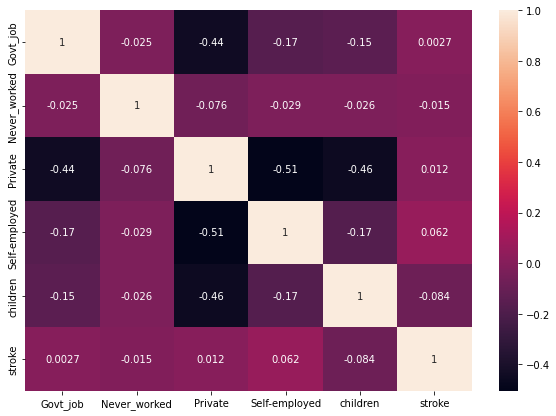

In [12]:
# Genero un mapa de calor para poder ver la correlación de los tipos de trabajo con la target.
plt.figure(figsize=(10,7))
sns.heatmap(df_work_merge.corr(), annot=True)

In [13]:
# Ahora ya puedo asignar un valor númerico a los diferentes tipos de trabajo que se ajusta a los datos en función de su correlación con la target.
work_type_dict = {'children': -2, 'Never_worked': -1, 'Govt_job': 0, 'Private': 1, 'Self-employed': 2}
df['work'] = df['work_type'].replace(work_type_dict)
df.drop(columns='work_type', inplace=True)

En la columna *smoking_status* existe una categoría *Unknown* en la que se recogen los datos para aquellas instancias sobre las que no se tiene información. Por esa razón, decido aplicar un valor númerico superior a 0 a todas las categorías, siendo el 1 para *Unknown*.

In [14]:
smoking_status_dict = {'Unknown': 1, 'formerly smoked': 2, 'never smoked': 3, 'smokes': 4}
df['smoke'] = df['smoking_status'].replace(smoking_status_dict)
df.drop(columns='smoking_status', inplace=True)

### TRATAMIENTO DEL RESTO DE VARIABLES

Decido tratar los datos *NaN* de la columna *bmi* aplicando un *KNNImputer*.

In [15]:
imputer = KNNImputer(n_neighbors = 6)
df['bmi'] = imputer.fit_transform(np.array(df['bmi']).reshape(-1,1))

Redondeo de la variable *age*.

In [16]:
df['age'] = df['age'].apply(lambda x: round(x))

Elimino las columnas de tipo *object* y me quedo sólo con las columnas que voy a utilizar para la implementación de los diferentes modelos.

In [17]:
df_clean = df.copy()

In [18]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   int32  
 1   age                5110 non-null   int64  
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   avg_glucose_level  5110 non-null   float64
 5   bmi                5110 non-null   float64
 6   stroke             5110 non-null   int64  
 7   married            5110 non-null   int32  
 8   residence_urban    5110 non-null   int32  
 9   work               5110 non-null   int64  
 10  smoke              5110 non-null   int64  
dtypes: float64(2), int32(3), int64(6)
memory usage: 419.2 KB


### CREACIÓN DATASET DE TEST

In [19]:
test = df_clean.copy()
test.sort_values(by='id', inplace=True)
test = test.iloc[:600, :]
target = test['stroke']
test.drop(columns=['stroke'], inplace=True)
test.to_csv(r'C:\Users\dfvin\OneDrive\Documentos\Bootcamp_DS\Alumno\3-Machine_Learning\Proyecto_Machine_Learning\src\data\raw\test.csv')

### CREACIÓN DEL DATASET CON LA TARGET DEL DATASET DE TEST

In [20]:
target.to_csv(r'C:\Users\dfvin\OneDrive\Documentos\Bootcamp_DS\Alumno\3-Machine_Learning\Proyecto_Machine_Learning\src\data\raw\test_target.csv') 

### CREACIÓN DATASET DE TRAIN

In [21]:
train = df_clean.copy()
train.sort_values(by='id', inplace=True)
train = train.iloc[601: , :]
train.to_csv(r'C:\Users\dfvin\OneDrive\Documentos\Bootcamp_DS\Alumno\3-Machine_Learning\Proyecto_Machine_Learning\src\data\raw\train.csv') 

### OVERSAMPLING

In [51]:
X = train.drop(columns='stroke')
y = train['stroke']

oversample = RandomOverSampler(sampling_strategy=0.60)

X_over, y_over = oversample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.20, random_state=42)

### FUNCION MOSTRAR RESULTADOS

In [59]:
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(9,6))
    sns.heatmap(conf_matrix, annot=True)
    plt.title('Confusion matrix')
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    print (classification_report(y_test, pred_y))

### HYPERPARAMETER TUNING

In [52]:
svm_model = SVC(kernel='rbf', C=30, gamma='auto')
svm_model.fit(X_train, y_train)
svm_model.score(X_test, y_test)

0.98761835396941

In [53]:
C = [1, 10, 20]
kernel = ['rbf', 'linear']

clf = GridSearchCV(SVC(gamma='auto'), {'C': C, 'kernel':kernel}, cv=5, return_train_score=False)

clf.fit(X_train, y_train)
clf.cv_results_

{'mean_fit_time': array([ 0.48742504, 12.30682063,  0.45904603, 54.4058537 ,  0.46199985,
        67.60954933]),
 'std_fit_time': array([6.14635309e-03, 4.78829828e+00, 8.09382628e-03, 8.86284901e+00,
        6.81248598e-03, 8.31029814e+00]),
 'mean_score_time': array([0.20741048, 0.02840281, 0.19080019, 0.02841835, 0.19335103,
        0.02459989]),
 'std_score_time': array([0.00149402, 0.0004897 , 0.00271356, 0.00138592, 0.00381977,
        0.0007981 ]),
 'param_C': masked_array(data=[1, 1, 10, 10, 20, 20],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_kernel': masked_array(data=['rbf', 'linear', 'rbf', 'linear', 'rbf', 'linear'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1, 'kernel': 'rbf'},
  {'C': 1, 'kernel': 'linear'},
  {'C': 10, 'kernel': 'rbf'},
  {'C': 10, 'kernel': 'linear'},
  {'C': 20, 'kernel': 'rbf'},
  {'

In [54]:
clf_results = pd.DataFrame(clf.cv_results_)
clf_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.487425,0.006146,0.207410,0.001494,1,rbf,"{'C': 1, 'kernel': 'rbf'}",0.986351,0.980892,0.984517,0.974499,0.988160,0.982884,0.004833,3
1,12.306821,4.788298,0.028403,0.000490,1,linear,"{'C': 1, 'kernel': 'linear'}",0.757962,0.760692,0.781421,0.770492,0.770492,0.768212,0.008325,4
2,0.459046,0.008094,0.190800,0.002714,10,rbf,"{'C': 10, 'kernel': 'rbf'}",0.985441,0.985441,0.984517,0.979964,0.989071,0.984887,0.002915,1
3,54.405854,8.862849,0.028418,0.001386,10,linear,"{'C': 10, 'kernel': 'linear'}",0.763421,0.761601,0.772313,0.768670,0.765027,0.766207,0.003840,6
4,0.462000,0.006812,0.193351,0.003820,20,rbf,"{'C': 20, 'kernel': 'rbf'}",0.985441,0.985441,0.984517,0.979964,0.989071,0.984887,0.002915,1
5,67.609549,8.310298,0.024600,0.000798,20,linear,"{'C': 20, 'kernel': 'linear'}",0.762511,0.764331,0.779599,0.769581,0.756831,0.766571,0.007683,5


In [55]:
clf_results[['param_C', 'param_kernel', 'mean_test_score']]

,param_C,param_kernel,mean_test_score
0,1,rbf,0.982884
1,1,linear,0.768212
2,10,rbf,0.984887
3,10,linear,0.766207
4,20,rbf,0.984887
5,20,linear,0.766571


In [56]:
clf.best_score_

0.984886906626491

In [57]:
clf.best_params_

{'C': 10, 'kernel': 'rbf'}

In [58]:
clf_best = clf.best_estimator_

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       569
           1       0.17      0.06      0.09        31

    accuracy                           0.94       600
   macro avg       0.56      0.52      0.53       600
weighted avg       0.91      0.94      0.92       600



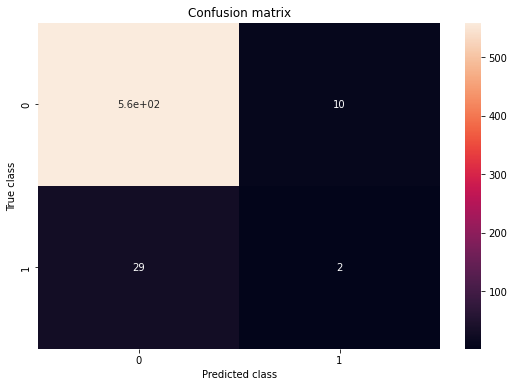

In [68]:
clf_preds_test = clf_best.predict(test)
mostrar_resultados(target, clf_preds_test)

In [35]:
rs = RandomizedSearchCV(SVC(gamma='auto'),
    {'C':C, 
    'kernel':kernel
    },
    cv=5,
    return_train_score=False,
    n_iter=2
    )

rs.fit(X_train, y_train)
rs_results = pd.DataFrame(rs.cv_results_)[['param_C', 'param_kernel', 'mean_test_score']]

In [36]:
rs_results

,param_C,param_kernel,mean_test_score
0,1,rbf,0.953422
1,20,linear,0.953739


In [38]:
n_estimators = [1, 5, 10]

model_params = {
    'svm': {
        'model': SVC(gamma='auto'),
        'params': {
            'C': C,
            'kernel': kernel
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': n_estimators
        }
    },
    'logistic_regression': {
        'model': LogisticRegression(solver='liblinear', multi_class='auto'),
        'params': {
            'C': n_estimators
        }
    }
}

In [39]:
scores = []

for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

In [40]:
cfl_gs_results = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
cfl_gs_results

,model,best_score,best_params
0,svm,0.953739,"{'C': 1, 'kernel': 'linear'}"
1,random_forest,0.950571,{'n_estimators': 10}
2,logistic_regression,0.953423,{'C': 5}


In [43]:
svc = SVC(gamma='auto', C=1, kernel='linear')

svc.fit(X_train, y_train)

SVC(C=1, gamma='auto', kernel='linear')

In [45]:
svc_preds = svc.predict(X_test)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1281
           1       0.00      0.00      0.00        72

    accuracy                           0.95      1353
   macro avg       0.47      0.50      0.49      1353
weighted avg       0.90      0.95      0.92      1353



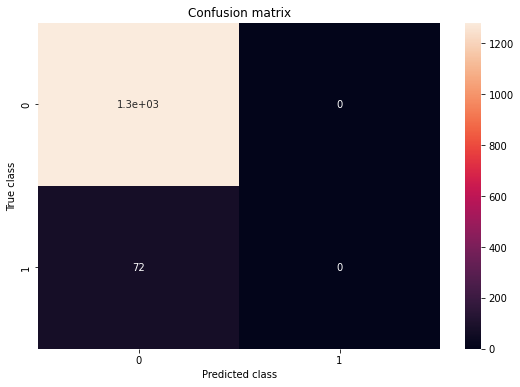

In [47]:
mostrar_resultados(y_test, svc_preds)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       569
           1       0.00      0.00      0.00        31

    accuracy                           0.95       600
   macro avg       0.47      0.50      0.49       600
weighted avg       0.90      0.95      0.92       600



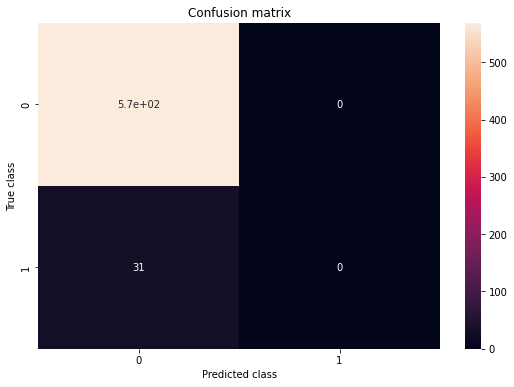

In [67]:
svc_preds_test = svc.predict(test)
mostrar_resultados(target, svc_preds_test)

### HYPERPARAMETER TUNING 2

In [89]:
over  = SMOTE(k_neighbors=6)

X, y = over.fit_resample(X, y)

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify = y, random_state=42)

##### RANDOM FOREST

In [91]:
rf = RandomForestClassifier()

n_estimators = [100,500,700,1000]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

grid = {'n_estimators': n_estimators,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'bootstrap': bootstrap}

rf_search = RandomizedSearchCV(estimator = rf, param_distributions = grid, cv = 5, verbose=1, n_jobs=-1)

In [93]:
rf_search.fit(X_train, y_train)
rf_preds = rf_search.predict(X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


              precision    recall  f1-score   support

           0       0.95      0.92      0.94       569
           1       0.12      0.19      0.14        31

    accuracy                           0.88       600
   macro avg       0.53      0.56      0.54       600
weighted avg       0.91      0.88      0.90       600



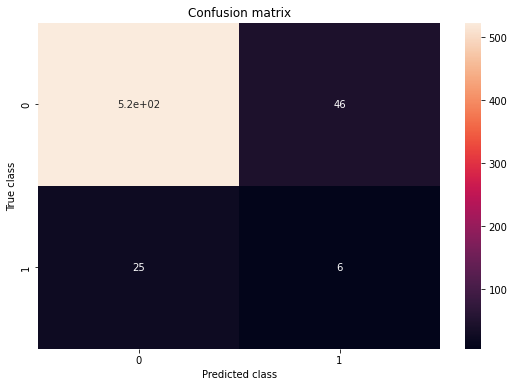

In [115]:
rf_preds_test = rf_search.predict(test)
mostrar_resultados(target, rf_preds_test)

In [102]:
gbr = GradientBoostingClassifier()

score = recall_score

parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "min_samples_split": [1,2,3],
    "min_samples_leaf": [1,2,3],
    'max_depth' : [None, 2,3,5,10],
    #"subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[100, 300, 500, 1000],
    "warm_start" : [False, True]
    
    }
#gbr_search = RandomizedSearchCV(estimator = gbr, param_distributions = parameters, cv = 5, verbose = 2, n_jobs = -1)
gbr_search = RandomizedSearchCV(estimator = gbr,param_distributions = parameters, scoring = score,cv = 5, verbose = 2, n_jobs = -1)

In [103]:
gbr_search.fit(X_train, y_train)
gbr_preds = gbr_search.predict(X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


              precision    recall  f1-score   support

           0       0.95      0.88      0.92       569
           1       0.07      0.16      0.10        31

    accuracy                           0.85       600
   macro avg       0.51      0.52      0.51       600
weighted avg       0.91      0.85      0.87       600



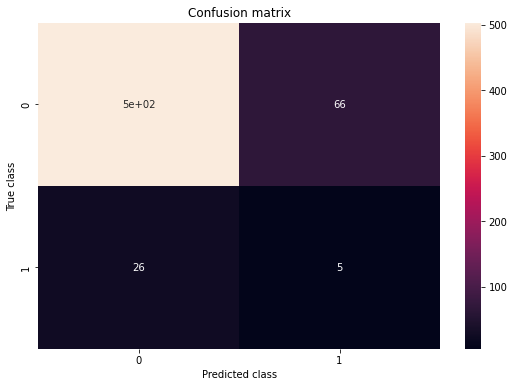

In [109]:
gbr_preds_test = gbr_search.predict(test)
mostrar_resultados(target, gbr_preds_test)

In [105]:
knn = KNeighborsClassifier()

score = recall_score

parameters_KNN = {
    'n_neighbors': (1,30, 1),
    'leaf_size': (20,40,1),
    'p': (1,2),
    'weights': ('uniform', 'distance'),
    'metric': ('minkowski', 'chebyshev')
}
knn_search = RandomizedSearchCV(estimator = knn, param_distributions = parameters_KNN, scoring = score,cv = 5, verbose = 2, n_jobs = -1)

In [106]:
knn_search.fit(X_train, y_train)
knn_preds = knn_search.predict(X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


              precision    recall  f1-score   support

           0       0.95      0.84      0.89       569
           1       0.06      0.19      0.10        31

    accuracy                           0.81       600
   macro avg       0.51      0.52      0.49       600
weighted avg       0.90      0.81      0.85       600



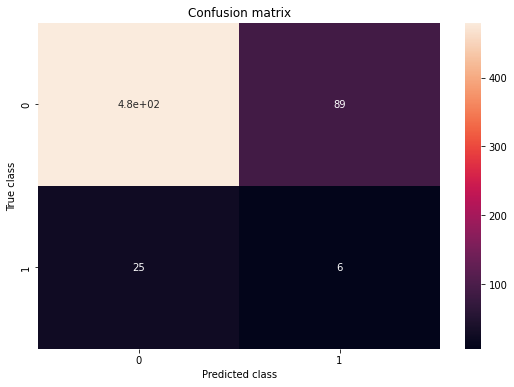

In [110]:
knn_preds_test = knn_search.predict(test)
mostrar_resultados(target, knn_preds_test)